In [126]:
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.linear_model import SGDClassifier
from math import exp
from random import random

In [127]:
def sigmoid(x):
    return 1 / (1 + exp(-x))

In [128]:
def take_mean(arr):
  sum = 0
  for i in arr:
    sum += i
  mean = sum/len(arr)
  
  return mean

In [130]:
class MyLogisticRegression:
    def __init__(self):
        self.intercept_ = 0.0
        self.coefficient_ = []
        self.loss = []
    def fit(self, x, y, learning_rate=0.001, no_epochs=1000):
        self.coefficient_ = [random() for _ in range(len(x[0]) + 1)]
        
        # Antrenează modelul utilizând algoritmul de învățare SGD(metoda gradientului descrescator stocastic)
        for epoch in range(no_epochs):
            epoch_loss = []
            for i in range(len(x)):
                y_computed = sigmoid(self.evaluate(x[i], self.coefficient_))
                crt_error = y_computed - y[i]
                epoch_loss.append(crt_error)
                
                # Actualizează coeficienții folosind regula de actualizare a gradientului
                for j in range(0, len(x[0])):
                    self.coefficient_[j + 1] = self.coefficient_[j + 1] - learning_rate * crt_error * x[i][j] # !!! inmultire derivata sigmoid
                self.coefficient_[0] = self.coefficient_[0] - learning_rate * crt_error * 1
            
            # Calculează media erorilor pentru această epocă și o adaugă la lista loss
            self.loss.append(take_mean(epoch_loss))
        
        # Stabilește interceptul și coeficienții modelului
        self.intercept_ = self.coefficient_[0]
        self.coefficient_ = self.coefficient_[1:]

    def evaluate(self, xi, coefficient):
        # Calculează valoarea estimată a lui yi pentru un vector xi și coeficienții modelului
        yi = coefficient[0]
        for j in range(len(xi)):
            yi += coefficient[j + 1] * xi[j]
        return yi

    def predict_one_sample(self, sample_features):
        threshold = 0.5
        coefficients = [self.intercept_] + [c for c in self.coefficient_]
        
        # Calculează valoarea estimată a etichetei pentru un singur sample
        computed_float_value = self.evaluate(sample_features, coefficients)
        computed01_value = sigmoid(computed_float_value)
        computed_label = 0 if computed01_value < threshold else 1
        return computed_label

    def predict(self, in_test):
        # Calculează etichetele estimate pentru setul de testare
        computed_labels = [self.predict_one_sample(sample) for sample in in_test]
        return computed_labels
        

In [131]:
class MyLogisticRegressionMultipleLabels:

    def __init__(self):
        self.intercept_ = []
        self.coefficient_ = []

    def fit_batch(self, x, y, learning_rate=0.0001, no_epochs=1000):
        self.coefficient_ = []
        self.intercept_ = []
        labels = list(set(y))
        
        # Antrenează modelul utilizând algoritmul de învățare batch
        for label in labels:
            coefficient = [random() for _ in range(len(x[0]) + 1)]
            for _ in range(no_epochs):
                errors = [0] * len(coefficient)
                
                # Calculează erorile pentru fiecare input și output
                for input, output in zip(x, y):
                    y_computed = sigmoid(self.evaluate(input, coefficient))
                    error = y_computed - 1 if output == label else y_computed
                    for i, xi in enumerate([1] + list(input)):
                        errors[i] += error * xi
                
                # Actualizează coeficienții folosind regula de actualizare a gradientului
                for i in range(len(coefficient)):
                    coefficient[i] = coefficient[i] - learning_rate * errors[i]
            
            # Adaugă interceptul și coeficienții pentru eticheta curentă în listele corespunzătoare
            self.intercept_.append(coefficient[0])
            self.coefficient_.append(coefficient[1:])

    def fit(self, x, y, learning_rate=0.001, no_epochs=1000):
        self.intercept_ = []
        self.coefficient_ = []
        labels = list(set(y))
        
        # Antrenează modelul utilizând algoritmul de învățare SGD (Stochastic Gradient Descent)
        for label in labels:
            coefficient = [random() for _ in range(len(x[0]) + 1)]
            for _ in range(no_epochs):
                for input, output in zip(x, y):
                    y_computed = sigmoid(self.evaluate(input, coefficient))
                    error = y_computed - 1 if output == label else y_computed
                    for j in range(len(x[0])):
                        coefficient[j + 1] = coefficient[j + 1] - learning_rate * error * input[j]
                    coefficient[0] = coefficient[0] - learning_rate * error
            
            # Adaugă interceptul și coeficienții pentru eticheta curentă în listele corespunzătoare
            self.intercept_.append(coefficient[0])
            self.coefficient_.append(coefficient[1:])

    def evaluate(self, xi, coefficient):
        # Calculează valoarea estimată a lui yi pentru un vector xi și coeficienții modelului
        yi = coefficient[0]
        for j in range(len(xi)):
            yi += coefficient[j + 1] * xi[j]
        return yi


    def predict_one_sample(self, sample_features):
        predictions = []
        
        # Calculează valorile estimate pentru fiecare etichetă și le adaugă în lista predictions
        for intercept, coefficient in zip(self.intercept_, self.coefficient_):
            computed_value = self.evaluate(sample_features, [intercept] + coefficient)
            predictions.append(sigmoid(computed_value))
        
        # Returnează indicele etichetei cu cea mai mare valoare estimată
        return predictions.index(max(predictions))

    def predict(self, in_test):
        # Calculează etichetele prezise pentru fiecare sample din setul de test
        computed_labels = [self.predict_one_sample(sample) for sample in in_test]
        return computed_labels

In [132]:
def load_data():
    # Încarcă setul de date breast cancer
    data = load_breast_cancer()
    
    # Extrage intrările și ieșirile din setul de date
    inputs = data['data']
    outputs = data['target']
    
    # Extrage numele etichetelor de ieșire și numele caracteristicilor
    output_names = data['target_names']
    feature_names = list(data['feature_names'])
    
    # Extrage valoarea caracteristicii 'mean radius' și 'mean texture' pentru fiecare sample
    feature1 = [feat[feature_names.index('mean radius')] for feat in inputs]
    feature2 = [feat[feature_names.index('mean texture')] for feat in inputs]
    
    # Reorganizează intrările pentru a utiliza doar caracteristicile 'mean radius' și 'mean texture'
    inputs = [[feat[feature_names.index('mean radius')], feat[feature_names.index('mean texture')]] for feat in inputs]
    
    # Returnează intrările, ieșirile, numele etichetelor de ieșire, valorile caracteristicii 'mean radius'
    # și 'mean texture', și primele două nume de caracteristici
    return inputs, outputs, output_names, feature1, feature2, feature_names[:2]


In [133]:
def plot_data(inputs, outputs, output_names, feature_names, title=None):
    # Extrage etichetele unice din ieșiri
    labels = set(outputs)
    
    # Obține numărul de date
    no_data = len(inputs)
    
    # Parcurge fiecare etichetă și plotează punctele corespunzătoare în funcție de caracteristici
    for crt_label in labels:
        x = [inputs[i][0] for i in range(no_data) if outputs[i] == crt_label]
        y = [inputs[i][1] for i in range(no_data) if outputs[i] == crt_label]
        plt.scatter(x, y, label=output_names[crt_label])
    
    # Adaugă etichetele și titlul la grafic
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend()
    plt.title(title)
    
    # Afișează graficul
    plt.show()

def plot_histogram_feature(feature, variableName):
    # Plotează histograma pentru caracteristica dată
    plt.hist(feature, 10)
    
    # Adaugă titlul la histogramă
    plt.title('Histogram of ' + variableName)
    
    # Afișează histograma
    plt.show()

In [134]:
def train_and_test(inputs, outputs):
    # Generează un set de indici pentru a selecta eșantioanele de antrenament
    indexes = [i for i in range(len(inputs))]
    
    # Selectează un eșantion de antrenament aleator din datele de intrare
    train_sample = np.random.choice(indexes, int(0.8 * len(inputs)), replace=False)
    
    # Construiește eșantioanele de antrenament și testare utilizând indicii selectați
    train_inputs = [inputs[i] for i in train_sample]
    train_outputs = [outputs[i] for i in train_sample]
    test_inputs = [inputs[i] for i in indexes if i not in train_sample]
    test_outputs = [outputs[i] for i in indexes if i not in train_sample]
    
    # Returnează datele de antrenament și testare
    return train_inputs, train_outputs, test_inputs, test_outputs

def normalisation(train_data, test_data):
    # Inițializează scalatorul StandardScaler
    scaler = StandardScaler()
    
    # Verifică dacă datele de antrenament sunt unidimensionale
    if not isinstance(train_data[0], list):
        # Reshapează datele de antrenament și testare pentru a avea o formă adecvată pentru scalare
        train_data = [[d] for d in train_data]
        test_data = [[d] for d in test_data]
        
        # Potrivește scalatorul pe datele de antrenament și realizează normalizarea
        scaler.fit(train_data)
        normalisedTrainData = scaler.transform(train_data)
        normalisedTestData = scaler.transform(test_data)
        
        # Rearanjează datele normalizate pentru a reveni la forma unidimensională inițială
        normalisedTrainData = [el[0] for el in normalisedTrainData]
        normalisedTestData = [el[0] for el in normalisedTestData]
    else:
        # Potrivește scalatorul pe datele de antrenament și realizează normalizarea
        scaler.fit(train_data)
        normalisedTrainData = scaler.transform(train_data)
        normalisedTestData = scaler.transform(test_data)
    
    # Returnează datele de antrenament și testare normalizate
    return normalisedTrainData, normalisedTestData

In [135]:
def learn_by_tool(train_inputs, train_outputs, test_inputs, test_outputs):
    # Inițializează un clasificator de regresie logistică din biblioteca scikit-learn
    classifier = linear_model.LogisticRegression()
    
    # Antrenează clasificatorul pe datele de antrenament
    classifier.fit(train_inputs, train_outputs)
    
    # Obține coeficienții și interceptul clasificatorului antrenat
    w0, w1, w2 = classifier.intercept_[0], classifier.coef_[0][0], classifier.coef_[0][1]
    print('Classification model by tool: y =', w0, '+', w1, '* feat1 +', w2, '* feat2')
    
    # Realizează predicții pe datele de testare
    computed_outputs = classifier.predict(test_inputs)
    
    # Calculează scorul de acuratețe pe datele de testare
    print("Accuracy score:", classifier.score(test_inputs, test_outputs))
    
    # Returnează predicțiile
    return computed_outputs

def learn_by_me(train_inputs, train_outputs, test_inputs, test_outputs, dimensiuni):
    # Inițializează un clasificator de regresie logistică personalizat
    classifier = MyLogisticRegression()
    
    # Antrenează clasificatorul pe datele de antrenament
    classifier.fit(train_inputs, train_outputs)
    
    # Plotează evoluția pierderii pe parcursul antrenării
    plt.plot(classifier.loss, [index for index in range(len(classifier.loss))])
    plt.show()
    
    # Obține coeficienții și interceptul clasificatorului antrenat
    w0, w1, w2 = classifier.intercept_, classifier.coefficient_[0], classifier.coefficient_[1]
    print('Classification model by me: y =', w0, '+', w1, '* feat1 +', w2, '* feat2')
    
    # Realizează predicții pe datele de testare
    computed_outputs = [1 if sigmoid(w0 + w1 * el[0] + w2 * el[1]) > 0.5 else 0 for el in test_inputs]
    
    # Calculează scorul de acuratețe pe datele de testare
    no_data = len(test_inputs)
    accuracy = 0.0
    for i in range(no_data):
        if test_outputs[i] == computed_outputs[i]:
            accuracy += 1
    print("Accuracy score:", accuracy / no_data)

    dimensiuni = classifier.predict(dimensiuni)

    # Returnează predicțiile
    return computed_outputs, dimensiuni

In [136]:
def plot_predictions(inputs, real_outputs, computed_outputs, label_names, feature_names, title=None):
    # Obține lista de etichete unice
    labels = list(set(real_outputs))
    
    # Obține numărul total de date
    no_data = len(inputs)
    
    # Plotează punctele corespunzătoare predicțiilor corecte
    for crt_label in labels:
        x = [inputs[i][0] for i in range(no_data) if real_outputs[i] == crt_label and computed_outputs[i] == crt_label]
        y = [inputs[i][1] for i in range(no_data) if real_outputs[i] == crt_label and computed_outputs[i] == crt_label]
        plt.scatter(x, y, label=label_names[crt_label] + ' (correct)')
    
    # Plotează punctele corespunzătoare predicțiilor incorecte
    for crt_label in labels:
        x = [inputs[i][0] for i in range(no_data) if real_outputs[i] == crt_label and computed_outputs[i] != crt_label]
        y = [inputs[i][1] for i in range(no_data) if real_outputs[i] == crt_label and computed_outputs[i] != crt_label]
        plt.scatter(x, y, label=label_names[crt_label] + ' (incorrect)')
    
    # Setează etichetele axelor și titlul graficului
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)

    # Adaugă legenda și afișează graficul
    plt.legend()
    plt.show()


def calculate_performance(computed_outputs, test_outputs, method):
    # Calculează eroarea de clasificare
    error = 0.0
    for t1, t2 in zip(computed_outputs, test_outputs):
        if t1 != t2:
            error += 1
    error = error / len(test_outputs)
    
    # Afișează eroarea de clasificare
    print('Classification error by', method, ':', error)

In [137]:
def load_data_flowers():
    # Încarcă setul de date Iris
    data = load_iris()
    
    # Extrage intrările și ieșirile din setul de date
    inputs = data['data']
    outputs = data['target']
    
    # Extrage numele ieșirilor și numele caracteristicilor
    outputs_name = data['target_names']
    feature_names = list(data['feature_names'])
    
    # Extrage valorile caracteristicilor individuale
    feature1 = [feat[feature_names.index('sepal length (cm)')] for feat in inputs]
    feature2 = [feat[feature_names.index('sepal width (cm)')] for feat in inputs]
    feature3 = [feat[feature_names.index('petal length (cm)')] for feat in inputs]
    feature4 = [feat[feature_names.index('petal width (cm)')] for feat in inputs]
    
    # Rearanjează datele de intrare pentru a le avea sub formă de liste de caracteristici
    inputs = [[feat[feature_names.index('sepal length (cm)')],
               feat[feature_names.index('sepal width (cm)')],
               feat[feature_names.index('petal length (cm)')],
               feat[feature_names.index('petal width (cm)')]] for feat in inputs]
    
    # return inputs, outputs, outputs_name, feature1, feature2, feature3, feature4, feature_names
    return inputs, outputs, outputs_name, feature1, feature2, feature3, feature4, feature_names


In [139]:
import pandas as pd

def plot_data_four_features(inputs, outputs, output_names, feature_names, title=None):
    # Extrage valorile caracteristicilor individuale
    x = [i[0] for i in inputs]
    y = [i[1] for i in inputs]
    z = [i[2] for i in inputs]
    v = [i[3] for i in inputs]

    
    # Generează un grafic 3D folosind plotly express
    figure = px.scatter_3d(x=x, y=y, z=z, symbol=v, color=outputs, title=title,
                           labels=dict(x=feature_names[0], y=feature_names[1], z=feature_names[2],
                                       symbol=feature_names[3], color="Type"))

    
    # Actualizează aspectul graficului
    figure.update_layout(legend=dict(orientation="v", yanchor='top', xanchor="right"))
    
    # Afișează graficul
    figure.show()

In [140]:
def learn_by_tool_multi_label(train_inputs, train_outputs, test_inputs, test_outputs):
    # Creați un clasificator de regresie logistică
    classifier = linear_model.LogisticRegression()
    
    # Antrenați clasificatorul utilizând datele de antrenament
    classifier.fit(train_inputs, train_outputs)
    
    # Extrageți coeficienții și intercepția pentru fiecare etichetă
    w0, w1, w2, w3, w4 = classifier.intercept_[0], classifier.coef_[0][0], classifier.coef_[0][1], classifier.coef_[0][2], classifier.coef_[0][3]
    print('Classification model by tool first label: y =', w0, '+', w1, '* feat1 +', w2, '* feat2 +', w3, '* feat3 +', w4, '* feat4')
    w0, w1, w2, w3, w4 = classifier.intercept_[1], classifier.coef_[1][0], classifier.coef_[1][1], classifier.coef_[1][2], classifier.coef_[1][3]
    print('Classification model by tool second label: y =', w0, '+', w1, '* feat1 +', w2, '* feat2 +', w3, '* feat3 +', w4, '* feat4')
    w0, w1, w2, w3, w4 = classifier.intercept_[2], classifier.coef_[2][0], classifier.coef_[2][1], classifier.coef_[2][2], classifier.coef_[2][3]
    print('Classification model by tool third label: y =', w0, '+', w1, '* feat1 +', w2, '* feat2 +', w3, '* feat3 +', w4, '* feat4')
    
    # Calculează ieșirile prevăzute pentru datele de testare
    computed_outputs = classifier.predict(test_inputs)
    
    # Calculează scorul de acuratețe al clasificatorului
    print("Accuracy score:", classifier.score(test_inputs, test_outputs))
    
    return computed_outputs

def learn_by_me_multi_label(train_inputs, train_outputs, test_inputs, test_outputs, flower):
    classifier = MyLogisticRegressionMultipleLabels()
    classifier.fit_batch(train_inputs, train_outputs)
    w0, w1, w2, w3, w4 = classifier.intercept_[0], classifier.coefficient_[0][0], classifier.coefficient_[0][1], classifier.coefficient_[0][2], classifier.coefficient_[0][3]
    print('Classification model by me first label: y =', w0, '+', w1, '* feat1 +', w2, '* feat2 +', w3, '* feat3 +', w4, '* feat4')
    w0, w1, w2, w3, w4 = classifier.intercept_[1], classifier.coefficient_[1][0], classifier.coefficient_[1][1], classifier.coefficient_[1][2], classifier.coefficient_[1][3]
    print('Classification model by me second label: y =', w0, '+', w1, '* feat1 +', w2, '* feat2 +', w3, '* feat3 +', w4, '* feat4')
    w0, w1, w2, w3, w4 = classifier.intercept_[2], classifier.coefficient_[2][0], classifier.coefficient_[2][1], classifier.coefficient_[2][2], classifier.coefficient_[2][3]
    print('Classification model by me third label: y =', w0, '+', w1, '* feat1 +', w2, '* feat2 +', w3, '* feat3 +', w4, '* feat4')
    
    # Calculează ieșirile prevăzute pentru datele de testare
    computed_outputs = classifier.predict(test_inputs)
    
    # Calculează scorul de acuratețe al clasificatorului
    no_data = len(test_inputs)
    accuracy = 0.0
    for i in range(no_data):
        if test_outputs[i] == computed_outputs[i]:
            accuracy += 1
    print("Accuracy score:", accuracy / no_data)

    # Apelarea metodei predict_one_sample cu dimensiunile specifice
    specie_prezisa = classifier.predict(flower)
    
    return computed_outputs, specie_prezisa

In [141]:
def cross_validation(inputs, outputs):
    indexes = [i for i in range(len(inputs))]
    first_set_index = []
    second_set_index = []
    third_set_index = []
    forth_set_index = []
    fifth_set_index = []

    # Împărțirea setului de date în 5 subseturi echivalente folosind validare încrucișată
    for i in range(5):
        # Selectarea aleatorie a unui subset pentru fiecare iterație
        first_set_index = np.random.choice(indexes, int(0.2 * len(inputs)), replace=False)
        used = list(first_set_index)
        
        # Selecția aleatorie a celui de-al doilea subset, excluzând datele deja selectate
        second_set_index = np.random.choice([i for i in indexes if i not in used], int(0.2 * len(inputs)), replace=False)
        used += list(second_set_index)
        
        # Selecția aleatorie a celui de-al treilea subset, excluzând datele deja selectate
        third_set_index = np.random.choice([i for i in indexes if i not in used], int(0.20 * len(inputs)), replace=False)
        used += list(third_set_index)
        
        # Selecția aleatorie a celui de-al patrulea subset, excluzând datele deja selectate
        forth_set_index = np.random.choice([i for i in indexes if i not in used], int(0.20 * len(inputs)), replace=False)
        used += list(forth_set_index)
        
        # Celelalte date vor fi incluse în cel de-al cincilea subset
        fifth_set_index = [i for i in indexes if i not in used]

    # Construirea subseturilor pe baza indexilor obținuți
    first_set = {
        'inputs': [inputs[i] for i in first_set_index],
        'outputs': [outputs[i] for i in first_set_index]
    }
    second_set = {
        'inputs': [inputs[i] for i in second_set_index],
        'outputs': [outputs[i] for i in second_set_index]
    }
    third_set = {
        'inputs': [inputs[i] for i in third_set_index],
        'outputs': [outputs[i] for i in third_set_index]
    }
    forth_set = {
        'inputs': [inputs[i] for i in forth_set_index],
        'outputs': [outputs[i] for i in forth_set_index]
    }
    fifth_set = {
        'inputs': [inputs[i] for i in fifth_set_index],
        'outputs': [outputs[i] for i in fifth_set_index]
    }
    
    # Returnarea subseturilor rezultate
    return [first_set, second_set, third_set, forth_set, fifth_set]


def other_loss_function(train_inputs, train_outputs, test_inputs, test_outputs):
    # Antrenarea clasificatorului și evaluarea acurateței utilizând diferite funcții de pierdere
    classifier = SGDClassifier(loss='log_loss') ### !!
    classifier.fit(train_inputs, train_outputs)
    print('Accuracy score (log loss by tool):', classifier.score(test_inputs, test_outputs))
    
    classifier = SGDClassifier(loss='hinge')
    classifier.fit(train_inputs, train_outputs)
    print('Accuracy score (hinge loss by tool):', classifier.score(test_inputs, test_outputs))
    
    classifier = SGDClassifier(loss='squared_hinge')
    classifier.fit(train_inputs, train_outputs)
    print('Accuracy score (squared hinge loss by tool):', classifier.score(test_inputs, test_outputs))


In [123]:
def main_breast_cancer():
    # Funcția principală pentru setul de date cancer la sân
    
    # Încărcarea datelor și afișarea lor inițială
    print("Two classes:")
    inputs, outputs, outputNames, feature1, feature2, featureNames = load_data()
    plot_data(inputs, outputs, outputNames, featureNames, "Initial data")
    plot_histogram_feature(feature1, featureNames[0])
    plot_histogram_feature(feature2, featureNames[1])
    plot_histogram_feature(outputs, 'Cancer class')
    
    # Divizarea datelor în setul de antrenare și setul de testare
    trainInputs, trainOutputs, testInputs, testOutputs = train_and_test(inputs, outputs)
    
    # Normalizarea datelor de intrare
    trainInputs, testInputs = normalisation(trainInputs, testInputs)
    
    # Antrenarea și evaluarea clasificatorului folosind toolurile disponibile
    computedTestOutputs = learn_by_tool(trainInputs, trainOutputs, testInputs, testOutputs)
    
    # Afișarea rezultatelor obținute de tool
    plot_predictions(testInputs, testOutputs, computedTestOutputs, outputNames, featureNames, "Results by tool")
    
    # Calcularea performanței clasificatorului folosind tool ul
    calculate_performance(computedTestOutputs, testOutputs, "tool")
    print()

    dimensiuni = [[10, 18]]
    dim, dimensiuni = normalisation(dimensiuni, dimensiuni)
    
    # Antrenarea și evaluarea clasificatorului implementat de utilizator
    computedTestOutputs, prezicere = learn_by_me(trainInputs, trainOutputs, testInputs, testOutputs, dimensiuni)
    
    # Afișarea rezultatelor obținute de utilizator
    plot_predictions(testInputs, testOutputs, computedTestOutputs, outputNames, featureNames, "Results by me")
    
    # Calcularea performanței clasificatorului implementat de utilizator
    calculate_performance(computedTestOutputs, testOutputs, "me")

    print('Forma de cancer prezisa pentru datele date:', outputNames[prezicere[0]])

def main_flowers():
    # Funcția principală pentru setul de date flori
    
    # Încărcarea datelor și afișarea lor inițială
    inputs, outputs, outputNames, feature1, feature2, feature3, feature4, featureNames = load_data_flowers()
    # plot_data_four_features(inputs, outputs, outputNames, featureNames, "Initial data for flowers")
    plot_histogram_feature(feature1, featureNames[0])
    plot_histogram_feature(feature2, featureNames[1])
    plot_histogram_feature(feature3, featureNames[2])
    plot_histogram_feature(feature4, featureNames[3])
    plot_histogram_feature(outputs, 'Flowers class')
    
    # Divizarea datelor în setul de antrenare și setul de testare
    trainInputs, trainOutputs, testInputs, testOutputs = train_and_test(inputs, outputs)
    
    # Normalizarea datelor de intrare
    trainInputs, testInputs = normalisation(trainInputs, testInputs)
    
    # Antrenarea și evaluarea clasificatorului folosind toolurile disponibile pentru probleme cu mai multe etichete
    computedTestOutputs = learn_by_tool_multi_label(trainInputs, trainOutputs, testInputs, testOutputs)
    
    # Afișarea rezultatelor obținute de tool pentru primele două caracteristici
    plot_predictions(testInputs, testOutputs, computedTestOutputs, outputNames, featureNames[:2], "Results by tool")
    
    calculate_performance(computedTestOutputs, testOutputs, "tool")
    print()

    # floare de prezis
    dimensiuni = [[5.35, 3.85, 1.25, 0.4]]

    dimensiuni2, dimensiuni = normalisation(dimensiuni, dimensiuni)


    # Antrenarea și evaluarea clasificatorului implementat de utilizator pentru probleme cu mai multe etichete
    computedTestOutputs, specie_prezisa = learn_by_me_multi_label(trainInputs, trainOutputs, testInputs, testOutputs, dimensiuni)
    
    # Afișarea rezultatelor obținute de utilizator pentru primele două caracteristici
    plot_predictions(testInputs, testOutputs, computedTestOutputs, outputNames, featureNames[:2], "Results by me")
    
    # Calcularea performanței clasificatorului implementat de utilizator
    calculate_performance(computedTestOutputs, testOutputs, "me")
    print()
    
    print("Cross validation:")
    # Validare încrucișată pentru evaluarea performanței clasificatorului implementat de utilizator
    data = cross_validation(inputs, outputs)
    for index in range(5):
        testInputs = data[index]['inputs']
        testOutputs = data[index]['outputs']
        trainInputs = []
        trainOutputs = []
        
        # Construirea setului de antrenare folosind celelalte subseturi
        for dictionary in data[:index] + data[index + 1:]:
            trainInputs += dictionary['inputs']
            trainOutputs += dictionary['outputs']

        # Normalizarea datelor de intrare pentru seturile de antrenare și testare
        trainInputs, testInputs = normalisation(trainInputs, testInputs)
        
        # Antrenarea și evaluarea clasificatorului implementat de utilizator
        computedTestOutputs, specie_prezisa = learn_by_me_multi_label(trainInputs, trainOutputs, testInputs, testOutputs, dimensiuni)
        
        # Calcularea performanței clasificatorului implementat de utilizator
        calculate_performance(computedTestOutputs, testOutputs, "me")
        print()
    
    print("Other loss functions:")
    # Antrenarea și evaluarea clasificatorului folosind diferite funcții de pierdere
    trainInputs, trainOutputs, testInputs, testOutputs = train_and_test(inputs, outputs)
    trainInputs, testInputs = normalisation(trainInputs, testInputs)
    other_loss_function(trainInputs, trainOutputs, testInputs, testOutputs)

    # Specia prezisă pentru acele dimensiuni
    print("Specia prezisă pentru dimensiunile date:", outputNames[specie_prezisa[0]])



Two classes:


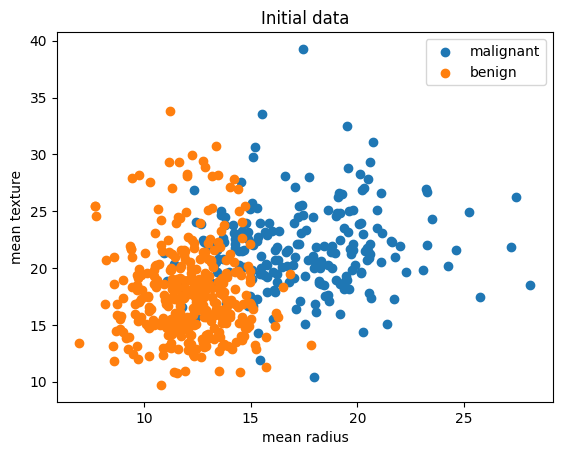

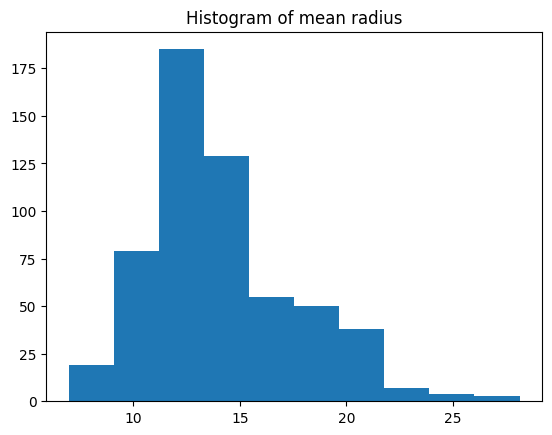

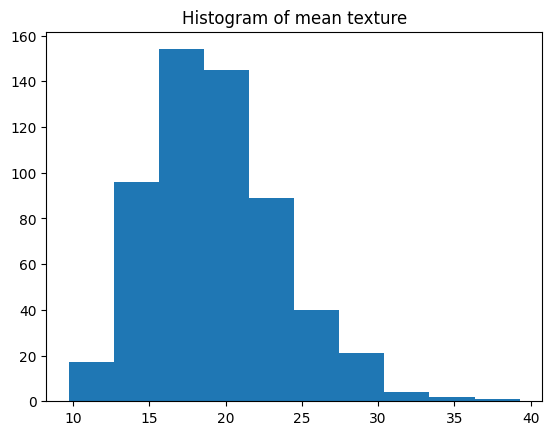

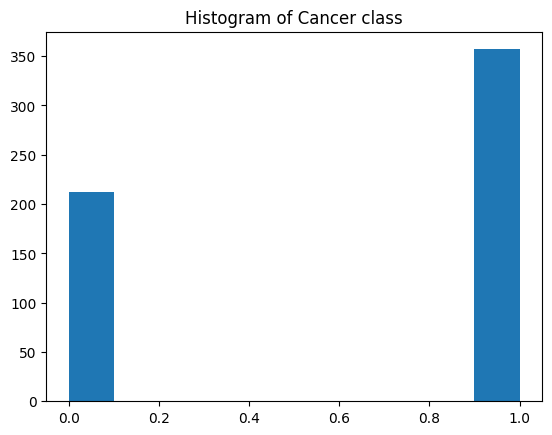

Classification model by tool: y = 0.8323828980166824 + -3.3313094906854723 * feat1 + -0.8480716848797144 * feat2
Accuracy score: 0.9122807017543859


In [ ]:
main_breast_cancer()
# main_flowers()